In [91]:
## КОГДА БУДЕТ ТЕСТОВЫЙ ФАЙЛ НАДО БУДЕТ ПОПРОБОВАТЬ СДЕЛАТЬ KBEST

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import nltk

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from IPython.display import Image, display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB



# nltk.download('wordnet')

#DATA TO LEARN
warnings.simplefilter('ignore')

path = '/home/alfadata/data/call_center/call-center/'

data1 = pd.read_excel(path+'08.2016.xlsx',sheetname=1,index_col=None)
cols_to_use = ['Процесс','Проблема (подробно)']
data1 = data1[cols_to_use]

data1=data1.rename(columns={'Процесс':'Продукты/Процессы','Проблема (подробно)':'Суть обращения'})

data2 = pd.read_excel(path+'09.2016.xlsx',sheetname=1,index_col=None)
cols_to_use = ['Продукты/Процессы','Суть обращения']
data2 = data2[cols_to_use]

data3 = pd.read_excel(path+'10.2016.xlsx',sheetname=1,index_col=None)
data3 = data3[cols_to_use]

data4 = pd.read_excel(path+'11.2016.xlsx',sheetname=1,index_col=None)
data4 = data4[cols_to_use]

data5 = pd.read_excel(path+'12.2016.xlsx',sheetname=1,index_col=None)
data5 = data5[cols_to_use]

data = pd.concat([data1,data2,data3,data4,data5],axis = 0)

data = data[~data['Продукты/Процессы'].isnull()]
data = data[~data['Суть обращения'].isnull()]
data = data.reset_index()

data = data.drop(['index'],axis=1)
data = data.set_value(data[data['Продукты/Процессы']=='SMS-оповещение/обзвон'].index,'Продукты/Процессы','SMS-оповещение')

data = data.set_value(data[data['Продукты/Процессы']=='общие вопросы'].index,'Продукты/Процессы','иное')

data = data.set_value(data[data['Продукты/Процессы']=='процесс не определен'].index,'Продукты/Процессы','иное')

data = data.set_value(data[data['Продукты/Процессы']=='Альфа-Бизнес Мобайл'].index,'Продукты/Процессы','АЛБО')

data = data.set_value(data[data['Продукты/Процессы']=='Закрытие счета'].index,'Продукты/Процессы','Закрытие счёта')

data = data.set_value(data[data['Продукты/Процессы']=='Открытие счета: консультации, заявки, открытие; полкл. АЛБО / доп.услуг'].index,'Продукты/Процессы','Открытие счета')

data = data.set_value(data[data['Продукты/Процессы']=='открытие первого счета'].index,'Продукты/Процессы','Открытие счета')

data = data.set_value(data[data['Продукты/Процессы']=='открытие второго и последующего счетов '].index,'Продукты/Процессы','Открытие счета')


q = data.groupby('Продукты/Процессы').count().reset_index()

q.sort('Суть обращения',ascending=0).head()



df = data
#X['Voice mail plan'] = X['Voice mail plan'].map({'Yes': 1, 'No': 0}) тоже возможная опция
df['Продукты/Процессы'][df['Продукты/Процессы']!='SMS-оповещение']=0
df['Продукты/Процессы'][df['Продукты/Процессы']=='SMS-оповещение']=1
df['Продукты/Процессы']= df['Продукты/Процессы'].astype(int)




#PREPROCESSING TEXT
class LemmaTokenizer(object): #tokenizer for CountVectorizer for stemming using Wordnet Corpora
      def __init__(self):
            self.wnl = WordNetLemmatizer()  
      def __call__(self, doc):  
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]    

vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),binary=True, ngram_range=(1, 4),min_df=1)


vect = vectorizer.fit(df['Суть обращения'])

bow = vect.transform(df['Суть обращения'])
print(bow.shape)
print(type(bow))



#TRAINING MODEL
seed = np.random.randint(10)

clf = LogisticRegression()
# print(np.mean(cross_val_score(clf, bow, df['Продукты/Процессы'], scoring='roc_auc', cv=5)))

x_train, x_test, y_train, y_test = train_test_split(bow, df['Продукты/Процессы'],random_state = 1,stratify=None)
print(x_train.shape)
print(x_test.shape)

C=10000
clf = LogisticRegression(C=C)
clf.fit(x_train, y_train)
print(metrics.log_loss(y_test, clf.predict_proba(x_test)[:, 1]))
print(roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1]))
print(metrics.recall_score(y_test, clf.predict(x_test)))
print(metrics.precision_score(y_test, clf.predict(x_test)))

(3050, 462415)
<class 'scipy.sparse.csr.csr_matrix'>
(2287, 462415)
(763, 462415)
0.225696886829
0.98054216222
0.875816993464
0.89932885906


#### Проверка предыдущих результатов модели с новыми

In [ ]:
0.227308039479
0.980627879567
0.869281045752
0.898648648649

In [89]:
params = {'C': np.logspace(-5, 5, 11)}

clf = LogisticRegression()
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score), cv=5)
cv.fit(bow,  df['Продукты/Процессы']);

In [90]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
9,0.862018,{'C': 10000.0}
10,0.861148,{'C': 100000.0}
8,0.858347,{'C': 1000.0}
7,0.855666,{'C': 100.0}
6,0.853057,{'C': 10.0}
5,0.850489,{'C': 1.0}
4,0.838616,{'C': 0.1}
3,0.815729,{'C': 0.01}
2,0.743427,{'C': 0.001}
1,0.647612,{'C': 0.0001}


In [11]:
metrics.f1_score(y_test, clf.predict(x_test))

0.8783783783783784

In [17]:
data['Продукты/Процессы'].value_counts()

0    2411
1     639
Name: Продукты/Процессы, dtype: int64

## Predict 

In [2]:
#INPUT TEST DATA

df2 = pd.DataFrame({ 'Продукты/Процессы' : pd.Categorical([1,0,1,0,0]),
                    'Суть обращения' : pd.Categorical(['на номер 8499XXXXXXXX поступают звонки от непонятных личностей из альфа банка','проблема с крдитом','На мой номер телефона 894564XXXXXX поступил звонок ','Прошу вас пройти небольшой опрос, это займет не более 5-ти минут вашего времени.','Нужно погасить задолженность по кредиту.Клиентом банка не являюсь,просьба уточнить по какой причине по ступают звонки данного вида,в случае некорректного поступления звонков просьба удалить данный номер из базы'])})
def predict_sms(df2):
    vect.transform(df2['Суть обращения'])
    return clf.predict_proba(vect.transform(df2['Суть обращения']))[:,1]

In [3]:
#PREDICT
predict_sms(df2)

array([ 0.69709436,  0.04559924,  0.19325377,  0.00588737,  0.8470252 ])

In [90]:
#read EXCEL and predict
def predict_sms(df2):
#     df2 = pd.read_excel(path+filename,sheetname=1,index_col=None)
#     cols_to_use = ['Продукты/Процессы','Суть обращения']
#     df2 = df2[cols_to_use]
#     df2['Продукты/Процессы'][df2['Продукты/Процессы']!='SMS-оповещение']=0
#     df2['Продукты/Процессы'][df2['Продукты/Процессы']=='SMS-оповещение']=1
    df2['Продукты/Процессы']= df2['Продукты/Процессы'].astype(int)
    vect.transform(df2['Суть обращения'])
    y_test = df2['Продукты/Процессы']
    auc = roc_auc_score(y_test, clf.predict_proba(vect.transform(df2['Суть обращения']))[:,1])
    logloss = metrics.log_loss(y_test, clf.predict_proba(vect.transform(df2['Суть обращения']))[:,1])
    print('logloss = %s'%logloss)
    print('auc = %s'%auc)
    return clf.predict_proba(vect.transform(df2['Суть обращения']))[:,1]

In [36]:
clf.predict_proba(vect.transform(df['Суть обращения']))[:,1]

array([ 0.00327829,  0.00723367,  0.00360848, ...,  0.00328753,
        0.00685758,  0.01133744])


## ##Finish


In [44]:
vect.vocabulary_

{'а также единственного': 95496,
 'предпринимателю': 347523,
 'документы находятся на': 167775,
 'like to know if': 86504,
 ', что п .': 29564,
 "альфа-банк '' . в": 100266,
 'также согласно договору на': 420080,
 'вычетом': 146559,
 '№ a1611101185 от': 461331,
 'меня заверили , что': 237352,
 'единственное ,': 172852,
 'правильные выводы и': 344708,
 'комиссии и остаток': 222170,
 'при этом данная': 351199,
 '370 605,00': 64641,
 'смс о задолжености': 395438,
 ') 604 19 06': 9729,
 '? ? настоящим': 78719,
 'решения нужны': 375776,
 'александрович 89162246851 не': 99315,
 'с ними знакомы': 381663,
 'счет закрыт по 115-фз': 413692,
 'на 50-ти вагонах': 247112,
 'zachislena uspeshno': 93149,
 'желает узнать': 176767,
 'postupilo 498700,00 ot ooo': 89315,
 '. объясните': 40232,
 'мной ,': 241329,
 'средств организации ,': 406777,
 'я не могу их': 457851,
 'и расторжении договора на': 195689,
 '11:33:29': 52342,
 'осипов p.s': 298370,
 'начале работы': 259241,
 'ответа так': 303514,
 'этом

#### Проверим, стоит ли нам увеличивать объем данных для улучшения классификатора модели

In [25]:
from sklearn.model_selection import learning_curve

In [79]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
def plot_learning_curve():
    train_sizes = np.linspace(0.3, 1, 20)
#     logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
#                            ('sgd_logit', SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha))])
    N_train, val_train, val_test = learning_curve(clf,
                                                  bow, df['Продукты/Процессы'], train_sizes=train_sizes,cv=5,
                                                  scoring='f1')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('F1')
    

In [47]:
print(np.linspace(0.05, 1, 20))

[ 0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6
  0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]


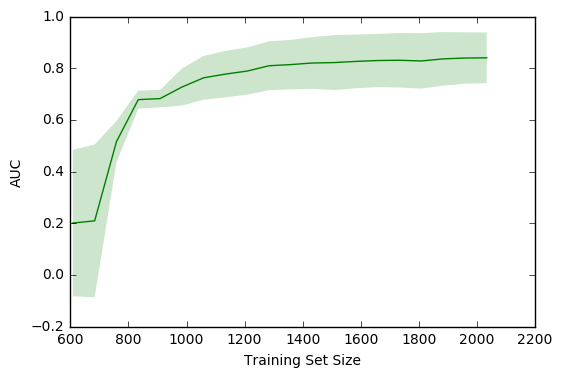

In [60]:
plot_learning_curve()#C10

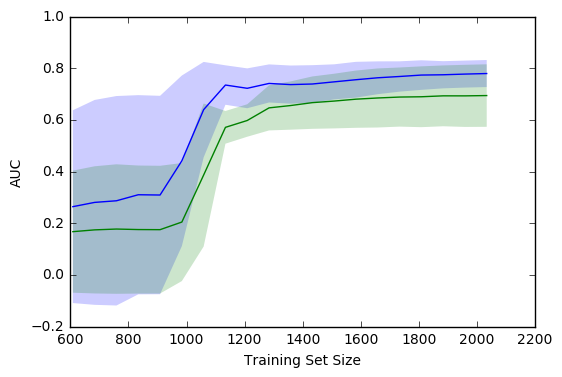

In [63]:
plot_learning_curve()#C0.1

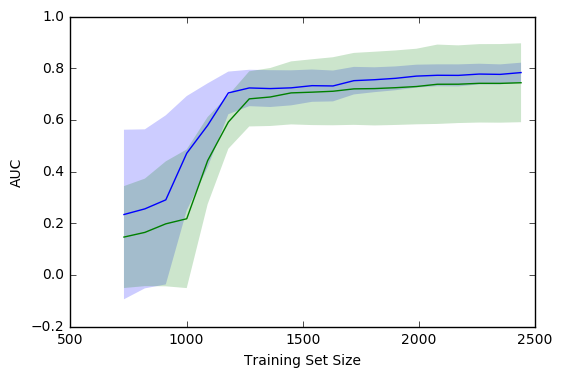

In [66]:
plot_learning_curve()#C0.1

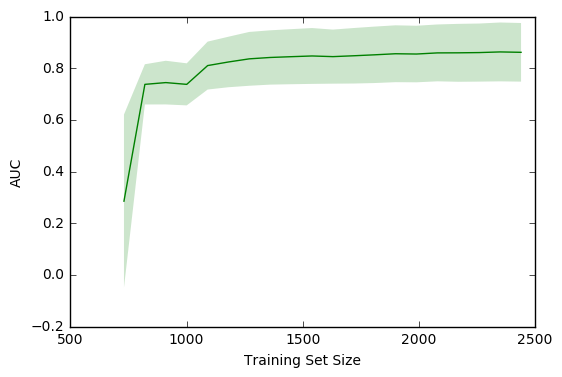

In [78]:
plot_learning_curve()#C100000